<a href="https://colab.research.google.com/github/pathakadithi/Tooth_Detection_yolov10/blob/main/ToothNumbengDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# mount Drive (optional) and checking GPU
from pathlib import Path
import os, sys, torch

# Uncomment to mount Google Drive if you want to load/save dataset there
from google.colab import drive
drive.mount('/content/drive')

print("Python", sys.version)
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
!nvidia-smi



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch: 2.8.0+cu126 CUDA available: True
Fri Aug 29 09:49:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A

In [2]:
# Installing ultralytics
!pip install -q -U ultralytics python-docx opencv-python-headless pandas matplotlib tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 139.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [3]:
import zipfile

zip_path = "/content/drive/MyDrive/ToothNumber_TaskDataset.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))



Extracted files: ['images', 'labels']


In [4]:
# Colab cell 4 — create train/val/test splits (80/10/10)
import random, shutil
from pathlib import Path

DATA_ROOT = Path('/content/dataset')   # change if different
IMG_EXTS = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
IMG_SRC_DIRS = [DATA_ROOT/'images', DATA_ROOT]  # try dataset/images first, else dataset root

# find images
image_paths = []
for base in IMG_SRC_DIRS:
    if base.exists():
        for ext in IMG_EXTS:
            image_paths.extend(list(base.rglob(f'*{ext}')))
image_paths = sorted(set(image_paths))
print(f"Found {len(image_paths)} images")

# Ensure matching label files exist (YOLO txt same stem)
pairs = []
miss_labels = 0
for imgp in image_paths:
    labp = imgp.with_suffix('.txt')
    if not labp.exists():
        # check alternative label location dataset/labels/<same stem>.txt
        alt = DATA_ROOT/'labels'/labp.name
        if alt.exists():
            labp = alt
        else:
            miss_labels += 1
            labp = None
    pairs.append((imgp, labp))
print(f"Missing labels for {miss_labels} images (if >0 check naming)")

# Filter pairs that actually have labels
pairs_with_labels = [p for p in pairs if p[1] is not None]
print("Usable image-label pairs:", len(pairs_with_labels))

# Shuffle & split
random.seed(42)
random.shuffle(pairs_with_labels)
N = len(pairs_with_labels)
n_train = int(0.8 * N)
n_val = int(0.1 * N)
n_test = N - n_train - n_val

train = pairs_with_labels[:n_train]
val   = pairs_with_labels[n_train:n_train+n_val]
test  = pairs_with_labels[n_train+n_val:]

print("Split sizes:", len(train), len(val), len(test))

# create directories
out_img = DATA_ROOT/'images'
out_lbl = DATA_ROOT/'labels'
for s in ('train','val','test'):
    (out_img/s).mkdir(parents=True, exist_ok=True)
    (out_lbl/s).mkdir(parents=True, exist_ok=True)

# copy files
def copy_pairs(list_pairs, split):
    for imgp, labp in list_pairs:
        tgt_img = out_img/split/imgp.name
        tgt_lab = out_lbl/split/labp.name
        shutil.copy2(imgp, tgt_img)
        shutil.copy2(labp, tgt_lab)

copy_pairs(train, 'train')
copy_pairs(val, 'val')
copy_pairs(test, 'test')

print("Done. Directory structure under", DATA_ROOT)
print("Images / labels train/val/test counts:",
      len(list((out_img/'train').iterdir())),
      len(list((out_img/'val').iterdir())),
      len(list((out_img/'test').iterdir())))


Found 497 images
Missing labels for 0 images (if >0 check naming)
Usable image-label pairs: 497
Split sizes: 397 49 51
Done. Directory structure under /content/dataset
Images / labels train/val/test counts: 397 49 51


In [5]:
# Colab cell 5 — write data.yaml
from pathlib import Path
DATA_ROOT = Path('/content/dataset')

data_yaml = f"""
train: {DATA_ROOT}/images/train
val:   {DATA_ROOT}/images/val
test:  {DATA_ROOT}/images/test

names:
  0: Canine (13)
  1: Canine (23)
  2: Canine (33)
  3: Canine (43)
  4: Central Incisor (21)
  5: Central Incisor (41)
  6: Central Incisor (31)
  7: Central Incisor (11)
  8: First Molar (16)
  9: First Molar (26)
  10: First Molar (36)
  11: First Molar (46)
  12: First Premolar (14)
  13: First Premolar (34)
  14: First Premolar (44)
  15: First Premolar (24)
  16: Lateral Incisor (22)
  17: Lateral Incisor (32)
  18: Lateral Incisor (42)
  19: Lateral Incisor (12)
  20: Second Molar (17)
  21: Second Molar (27)
  22: Second Molar (37)
  23: Second Molar (47)
  24: Second Premolar (15)
  25: Second Premolar (25)
  26: Second Premolar (35)
  27: Second Premolar (45)
  28: Third Molar (18)
  29: Third Molar (28)
  30: Third Molar (38)
  31: Third Molar (48)
"""
p = Path('/content/data.yaml')
p.write_text(data_yaml.strip())
print("Wrote", p)
print(p.read_text()[:1000])


Wrote /content/data.yaml
train: /content/dataset/images/train
val:   /content/dataset/images/val
test:  /content/dataset/images/test

names:
  0: Canine (13)
  1: Canine (23)
  2: Canine (33)
  3: Canine (43)
  4: Central Incisor (21)
  5: Central Incisor (41)
  6: Central Incisor (31)
  7: Central Incisor (11)
  8: First Molar (16)
  9: First Molar (26)
  10: First Molar (36)
  11: First Molar (46)
  12: First Premolar (14)
  13: First Premolar (34)
  14: First Premolar (44)
  15: First Premolar (24)
  16: Lateral Incisor (22)
  17: Lateral Incisor (32)
  18: Lateral Incisor (42)
  19: Lateral Incisor (12)
  20: Second Molar (17)
  21: Second Molar (27)
  22: Second Molar (37)
  23: Second Molar (47)
  24: Second Premolar (15)
  25: Second Premolar (25)
  26: Second Premolar (35)
  27: Second Premolar (45)
  28: Third Molar (18)
  29: Third Molar (28)
  30: Third Molar (38)
  31: Third Molar (48)


Sample image: /content/dataset/images/train/cate8-00251_jpg.rf.966e45eac4abc2b871f572e26592a206.jpg


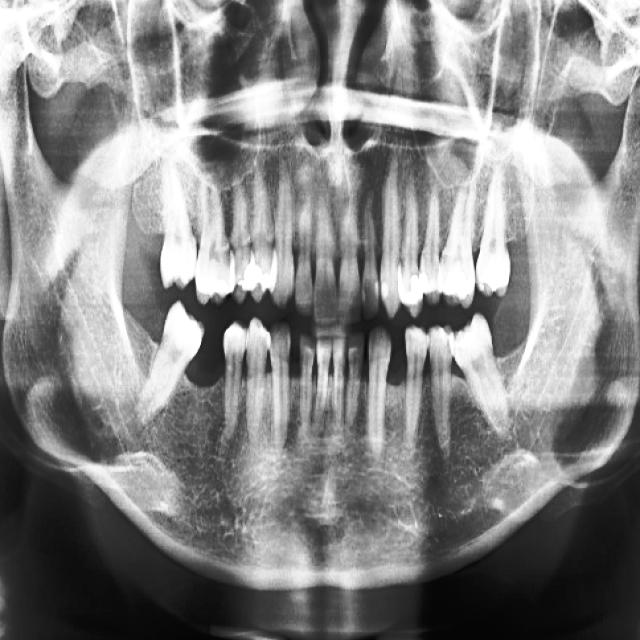

Label content:
 23 0.26640625 0.56640625 0.09921875 0.19140625
27 0.36640625 0.596875 0.0390625 0.1890625
14 0.40390625 0.59765625 0.0390625 0.19921875
3 0.43828125 0.60390625 0.0328125 0.1953125
18 0.48125 0.60625 0.025 0.16640625
5 0.50625 0.603125 0.02890625 0.14765625
6 0.53046875 0.6078125 0.01953125 0.1625
17 0.55546875 0.59453125 0.02890625 0.14765625
2 0.59375 0.61328125 0.0390625 0.2015625
13 0.653125 0.60546875 0.0375 0.19453125
26 0.69140625 0.61328125 0.03125 0.20625
10 0.75390625 0.5859375 0.090625 0.19296875
20 0.2796875 0.3546875 0.05546875 0.19296875
8 0.33671875 0.38359375 0.06171875 0.18515625
24 0.37578125 0.3796875 0.0328125 0.1890625
12 0.409375 0.3703125 0.0375 0.203125
0 0.4421875 0.36953125 0.0375 0.2265625
19 0.475 0.4015625 0.02890625 0.18671875
7 0.50859375 0.4125 0.0375 0.19296875
4 0.54765625 0.40625 0.0328125 0.2015625
16 0.58046875 0.4015625 0.025 0.19140625
1 0.61171875 0.36953125 0.0328125 0.25546875
15 0.64375 0.3921875 0.0390625 0.209375
25 0.6734375 

In [6]:
# Colab cell 6 — visualize a random sample and print its label
from IPython.display import Image, display
import random, io

img_dir = Path('/content/dataset/images/train')
imgs = list(img_dir.glob('*'))
if len(imgs)==0:
    print("No images found in train; check dataset path.")
else:
    sample = random.choice(imgs)
    print("Sample image:", sample)
    display(Image(str(sample)))
    lab = Path('/content/dataset/labels/train')/ (sample.stem + '.txt')
    if lab.exists():
        print("Label content:\n", lab.read_text())
    else:
        print("Label not found:", lab)


In [7]:
# Colab cell 7 — train using Python API (Ultralytics)
from ultralytics import YOLO
import glob, os

# Choose a pretrained yolov10 backbone: try 'yolov10n.pt' or 'yolov10s.pt' (tiny/small).
# Ultralytics supports model names; if not found it will download required weights.
model = YOLO('yolov10s.pt')   # small — good starting point

# Training parameters (tweak if OOM)
EPOCHS = 60         # change to 100 if you want more training
BATCH = 12          # reduce if you run out of VRAM (try 8)
IMGSZ = 640

# run
result = model.train(
    data='/content/data.yaml',
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    project='runs',
    name='yolov10_fdi',
    device=0,            # 0 means first GPU on Colab
    pretrained=True,
    verbose=True
)
print("Training finished. Check runs/detect/yolov10_fdi")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=N

In [8]:
# Colab cell 9 — evaluate on test split and save predictions images
from ultralytics import YOLO
import glob, shutil, os

best = sorted(glob.glob('runs/**/weights/best.pt', recursive=True))[-1]
print("Using best weights:", best)

model = YOLO(best)
# run val on the test split
res_test = model.val(data='/content/data.yaml', imgsz=640, split='test', save_json=True, save_dir='runs/test_eval')
print("Test metrics object:", res_test)

# run predictions over test images and save images
pred_run = model.predict(source='/content/dataset/images/test', imgsz=640, conf=0.25, save=True, project='runs', name='yolov10_fdi_preds')
print("Predictions saved to runs/detect/yolov10_fdi_preds")


Using best weights: runs/yolov10_fdi/weights/best.pt
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,230,384 parameters, 0 gradients, 21.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1176.2±737.1 MB/s, size: 89.8 KB)
val: Scanning /content/dataset/labels/test... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 1832.1it/s 0.0s
val: New cache created: /content/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.71it/s 5.6s
                   all         51       1485      0.873      0.864      0.919      0.622
           Canine (13)         50         50      0.907        0.9      0.952      0.651
           Canine (23)         48         49      0.869       0.81      0.901       0.55
           Canine (33)         49         49      0.694      0.741       0.72      0.448
           Canine (43)         

In [9]:
preds = model.predict(
    source='/content/dataset/images/test',
    imgsz=640,
    conf=0.25,
    save=True,
    project='runs',
    name='yolov10_fdi_preds'
)
print("Predictions saved under runs/detect/yolov10_fdi_preds/")




image 1/51 /content/dataset/images/test/05ff01fa-20250108-115407401.jpg: 640x640 1 Canine (13), 2 Canine (23)s, 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Central Incisor (31), 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First Premolar (14), 2 First Premolar (34)s, 2 First Premolar (44)s, 1 First Premolar (24), 2 Lateral Incisor (22)s, 1 Lateral Incisor (32), 2 Lateral Incisor (12)s, 1 Second Molar (17), 1 Second Molar (27), 1 Second Molar (37), 1 Second Premolar (15), 1 Second Premolar (25), 1 Second Premolar (35), 2 Second Premolar (45)s, 1 Third Molar (18), 1 Third Molar (28), 1 Third Molar (38), 1 Third Molar (48), 11.7ms
image 2/51 /content/dataset/images/test/124e696d-20240914-105651782.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 2 Central Incisor (41)s, 1 Central Incisor (31), 2 Central Incisor (11)s, 1 First Molar (16), 1 First

In [10]:
import glob, shutil
from pathlib import Path

run_root = '/content/runs/detect/yolov10_fdi/'
out = Path('/content/submission_files'); out.mkdir(exist_ok=True)

files_to_copy = [
    f'{run_root}/weights/best.pt',
    f'{run_root}/results.png',
    f'{run_root}/confusion_matrix.png',
    f'{run_root}/labels.jpg'
]

for f in files_to_copy:
    if Path(f).exists():
        shutil.copy(f, out / Path(f).name)
        print("Copied:", f)
    else:
        print("Missing:", f)

# Copy a few predictions
pred_imgs = glob.glob('/content/runs/detect/predict/*.jpg')
for p in pred_imgs[:5]:
    shutil.copy(p, out / Path(p).name)

print("Final submission folder:", list(out.iterdir()))


Missing: /content/runs/detect/yolov10_fdi//weights/best.pt
Missing: /content/runs/detect/yolov10_fdi//results.png
Missing: /content/runs/detect/yolov10_fdi//confusion_matrix.png
Missing: /content/runs/detect/yolov10_fdi//labels.jpg
Final submission folder: []


In [11]:
import glob, shutil
from pathlib import Path

out = Path('/content/submission_files')
out.mkdir(exist_ok=True)

# --- 1) Get latest training run ---
train_dirs = sorted(glob.glob('/content/runs/yolov10_fdi*'), key=os.path.getmtime)
train_dirs = [d for d in train_dirs if "_preds" not in d]  # only training runs
if not train_dirs:
    raise FileNotFoundError("No yolov10_fdi training runs found under /content/runs/")
train_root = train_dirs[-1]
print("Training run folder:", train_root)

# Copy important training artifacts
train_files = [
    f'{train_root}/weights/best.pt',
    f'{train_root}/results.png',
    f'{train_root}/confusion_matrix.png',
    f'{train_root}/labels.jpg'
]
for f in train_files:
    if Path(f).exists():
        shutil.copy(f, out / Path(f).name)
        print("Copied:", f)
    else:
        print("Missing:", f)

# --- 2) Get latest predictions run ---
pred_dirs = sorted(glob.glob('/content/runs/yolov10_fdi_preds*'), key=os.path.getmtime)
if pred_dirs:
    pred_root = pred_dirs[-1]
    print("Prediction run folder:", pred_root)

    pred_imgs = glob.glob(f'{pred_root}/*.jpg')
    for p in pred_imgs[:5]:  # copy up to 5 predictions
        shutil.copy(p, out / Path(p).name)
        print("Copied prediction:", p)

print("📂 Final submission folder:", list(out.iterdir()))






Training run folder: /content/runs/yolov10_fdi
Copied: /content/runs/yolov10_fdi/weights/best.pt
Copied: /content/runs/yolov10_fdi/results.png
Copied: /content/runs/yolov10_fdi/confusion_matrix.png
Copied: /content/runs/yolov10_fdi/labels.jpg
Prediction run folder: /content/runs/yolov10_fdi_preds2
Copied prediction: /content/runs/yolov10_fdi_preds2/cate1-00068_jpg.rf.7053b967f1a29660587386e1dc0b8a99.jpg
Copied prediction: /content/runs/yolov10_fdi_preds2/bd279a5f-20240920-115601588.jpg
Copied prediction: /content/runs/yolov10_fdi_preds2/b94abb31-20250429-142751426.jpg
Copied prediction: /content/runs/yolov10_fdi_preds2/cate7-00018_jpg.rf.43b411df058815e8b08c6aa100710187.jpg
Copied prediction: /content/runs/yolov10_fdi_preds2/1b000dc7-20240813-115604759.jpg
📂 Final submission folder: [PosixPath('/content/submission_files/cate1-00068_jpg.rf.7053b967f1a29660587386e1dc0b8a99.jpg'), PosixPath('/content/submission_files/bd279a5f-20240920-115601588.jpg'), PosixPath('/content/submission_files/

In [12]:
# Colab cell 11 — auto-create a docx report
from docx import Document
from docx.shared import Inches
import glob, pandas as pd, os

out = Path('/content/submission_files')
doc = Document()
doc.add_heading('OralVis — YOLOv10 Tooth Detection Report', level=1)
doc.add_paragraph('Dataset split: 80% train, 10% val, 10% test.')

# Attempt to find metrics in known files
metrics_text = ""
# common Ultralytics outputs: results.json / results.csv in run folder
possible = glob.glob(f'{run_root}/*results*') + glob.glob(f'{run_root}/**/results*', recursive=True)
# try to find a CSV with per-epoch metrics
csvs = [p for p in possible if p.endswith('.csv')]
if csvs:
    df = pd.read_csv(csvs[-1])
    metrics_text += "Found results CSV. Last-row metrics:\n"
    metrics_text += df.tail(1).to_string(index=False)
else:
    metrics_text += "No results.csv found automatically; please inspect runs/detect/* for precision/recall/mAP values saved by Ultralytics."

doc.add_paragraph(metrics_text)

# insert confusion matrix if present
conf_path = out/'confusion_matrix.png'
if (conf_path).exists():
    doc.add_heading('Confusion Matrix', level=2)
    doc.add_picture(str(conf_path), width=Inches(6))
else:
    # try in run folder
    alt_conf = Path(run_root)/'confusion_matrix.png'
    if alt_conf.exists():
        doc.add_heading('Confusion Matrix', level=2)
        doc.add_picture(str(alt_conf), width=Inches(6))
    else:
        doc.add_paragraph("Confusion matrix not found. Run validation to generate it (`yolo val ...`).")

# add sample predictions
doc.add_heading('Sample Predictions', level=2)
preds = list(out.glob('*.jpg')) + list(out.glob('*.png'))
for p in preds[:6]:
    doc.add_paragraph(p.name)
    doc.add_picture(str(p), width=Inches(5))

# save
doc_path = Path('/content/OralVis_report.docx')
doc.save(str(doc_path))
print("Saved report to", doc_path)


Saved report to /content/OralVis_report.docx


In [13]:
# Zip all files into one package
!zip -r /content/submission_package.zip /content/submission_files /content/OralVis_report.docx

# List the file to confirm
!ls -lh /content/submission_package.zip



  adding: content/submission_files/ (stored 0%)
  adding: content/submission_files/cate1-00068_jpg.rf.7053b967f1a29660587386e1dc0b8a99.jpg (deflated 3%)
  adding: content/submission_files/bd279a5f-20240920-115601588.jpg (deflated 2%)
  adding: content/submission_files/b94abb31-20250429-142751426.jpg (deflated 2%)
  adding: content/submission_files/cate7-00018_jpg.rf.43b411df058815e8b08c6aa100710187.jpg (deflated 3%)
  adding: content/submission_files/1b000dc7-20240813-115604759.jpg (deflated 2%)
  adding: content/submission_files/labels.jpg (deflated 48%)
  adding: content/submission_files/confusion_matrix.png (deflated 21%)
  adding: content/submission_files/best.pt (deflated 8%)
  adding: content/submission_files/results.png (deflated 7%)
  adding: content/OralVis_report.docx (deflated 0%)
-rw-r--r-- 1 root root 18M Aug 29 09:48 /content/submission_package.zip


In [14]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/submission_package.zip /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!cp /content/submission_package.zip /content/drive/MyDrive/


In [16]:
!mkdir -p /content/drive/MyDrive/OralVis_Project
!cp /content/submission_package.zip /content/drive/MyDrive/OralVis_Project/


In [17]:
!yolo task=detect mode=predict model=best.pt source=your_image.jpg



Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 956, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/yolo/model.py", line 81, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 151, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 295, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py", line 1549, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
    